In [1]:
import pandas as pd
df=pd.read_csv("dataset_base.csv")
df

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,10004,20001,2017-01,0.0,9.0,184.72927,184.72927,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,10003,20001,2017-01,0.0,17.0,143.49426,143.49426,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000
2,10002,20001,2017-01,0.0,17.0,38.68301,35.72806,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000
3,10001,20001,2017-01,0.0,11.0,99.43861,99.43861,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000
4,10084,20001,2017-01,0.0,1.0,0.22386,0.22386,0.00000,HC,ROPA LAVADO,Liquido,ARIEL,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460975,10159,21276,2019-12,0.0,0.0,0.00000,0.00000,1.05592,PC,PIEL1,Cara,NIVEA,140
9460976,10101,21276,2019-12,0.0,0.0,0.00000,0.00000,1.05592,PC,PIEL1,Cara,NIVEA,140
9460977,10154,21276,2019-12,0.0,0.0,0.00000,0.00000,1.05592,PC,PIEL1,Cara,NIVEA,140
9460978,10052,21276,2019-12,0.0,1.0,0.00594,0.00594,1.05592,PC,PIEL1,Cara,NIVEA,140


In [ ]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Cargar datos
df = pd.read_csv("dataset_base.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# Pivotear: filas = productos, columnas = fechas
df_pivot = df.pivot_table(index='product_id', columns='periodo', values='tn', aggfunc='sum').fillna(0)

# Asegurar formato [n_series, n_timestamps, 1]
X = df_pivot.values[:, :, np.newaxis]

# Normalizar (opcional pero recomendado para DTW)
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Clustering con DTW
n_clusters = 5  # podés cambiarlo según el caso
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = km_dtw.fit_predict(X_scaled)

# Guardar resultado
df_clusters = pd.DataFrame({
    'product_id': df_pivot.index,
    'cluster_dtw': labels
})
df_clusters.to_csv("dtw_clustersdatasetbase.csv", index=False)
print("Archivo dtw_clustersdatasetbase.csv generado correctamente.")


c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\tslearn_env\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all

✅ Archivo dtw_clustersdatasetbase.csv generado correctamente.


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datasets
df = pd.read_csv("dataset_base.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clustersdatasetbase.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

# Conversión a float32 explícita
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 722,
    'learning_rate': 0.26830103566346203,
    'max_depth': 8,
    'num_leaves': 302,
    'min_data_in_leaf': 65,
    'min_child_weight': 0.2723737879682162,
    'subsample': 0.6693558818396728,
    'subsample_freq': 3,
    'colsample_bytree': 0.9982366151830648,
    'colsample_bynode': 0.6808843764592971,
    'reg_alpha': 1.5889509640833777,
    'reg_lambda': 3.277536337616617,
    'max_bin': 502,
    'min_split_gain': 0.10250744462326401,
    'cat_smooth': 49.797959349843936,
    'random_state': 42,
    #'boosting_type':  'dart',
    'verbosity': -1,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 10. Validación
y_pred_val = modelo.predict(X_val)
print("MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 11. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Conversión a float32 para predicción
X_feb = feb_df[features].astype('float32')

# 12. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 0.85 * feb_df['tn_predicho'] + 0.15 * feb_df['febrero_hist']

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_datsetbasecondtw6.csv", index=False)
print("Predicción febrero 2020 guardada en prediccion_feb2020_datasetbasecondtw.csv")


📊 MAE en diciembre 2019: 8.194591057847333
✅ Predicción febrero 2020 guardada en prediccion_feb2020_datasetbasecondtw.csv


In [ ]:
#SIN CLUSTERIZACIÓN
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar dataset base
df = pd.read_csv("dataset_base.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 4. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 5. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 6. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 7. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 8. Entrenar modelo
mejores_params = {
    'n_estimators': 722,
    'learning_rate': 0.26830103566346203,
    'max_depth': 8,
    'num_leaves': 302,
    'min_data_in_leaf': 65,
    'min_child_weight': 0.2723737879682162,
    'subsample': 0.6693558818396728,
    'subsample_freq': 3,
    'colsample_bytree': 0.9982366151830648,
    'colsample_bynode': 0.6808843764592971,
    'reg_alpha': 1.5889509640833777,
    'reg_lambda': 3.277536337616617,
    'max_bin': 502,
    'min_split_gain': 0.10250744462326401,
    'cat_smooth': 49.797959349843936,
    'random_state': 42,
    #'boosting_type': 'dart',
    'verbosity': -1,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

X_feb = feb_df[features].astype('float32')

# 11. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 0.85 * feb_df['tn_predicho'] + 0.15 * feb_df['febrero_hist']

# 12. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_datasetbase_sinclusters.csv", index=False)
print("Predicción febrero 2020 guardada en prediccion_feb2020_datasetbase_sinclusters.csv")


📊 MAE en diciembre 2019: 7.848324998462937
✅ Predicción febrero 2020 guardada en prediccion_feb2020_datasetbase_sinclusters.csv


In [ ]:
#promedio 12m en vez de histórico febrero
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datasets
df = pd.read_csv("dataset_base.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clustersdatasetbase.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 5. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 6. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 7. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 8. Entrenar modelo
mejores_params = {
    'n_estimators': 722,
    'learning_rate': 0.26830103566346203,
    'max_depth': 8,
    'num_leaves': 302,
    'min_data_in_leaf': 65,
    'min_child_weight': 0.2723737879682162,
    'subsample': 0.6693558818396728,
    'subsample_freq': 3,
    'colsample_bytree': 0.9982366151830648,
    'colsample_bynode': 0.6808843764592971,
    'reg_alpha': 1.5889509640833777,
    'reg_lambda': 3.277536337616617,
    'max_bin': 502,
    'min_split_gain': 0.10250744462326401,
    'cat_smooth': 49.797959349843936,
    'random_state': 42,
    #'boosting_type': 'dart',
    'verbosity': -1,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 9. Validación
y_pred_val = modelo.predict(X_val)
print("MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 10. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

X_feb = feb_df[features].astype('float32')

# 11. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 0.65 * feb_df['tn_predicho'] + 0.35 * feb_df['media_movil_12m']

# 12. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_lgbmy12m1.csv", index=False)
print("Predicción febrero 2020 guardada en prediccion_feb2020_lgbmy12m1.csv")


📊 MAE en diciembre 2019: 8.194591057847333
✅ Predicción febrero 2020 guardada en prediccion_feb2020_lgbmy12m1.csv


In [ ]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_lgbmy12m1.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("top_40_corr.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo            tn
1  2017-02-01  10414.562270
2  2017-03-01  14360.257460
3  2017-04-01  12495.123440
4  2017-05-01  14867.309850
5  2017-06-01  14365.538740
6  2017-07-01  13124.215230
7  2017-08-01  14592.670290
8  2017-09-01  17528.125200
9  2017-10-01  17999.233710
10 2017-11-01  14961.253380
11 2017-12-01  12500.909020
12 2018-01-01  10131.945400
13 2018-02-01  11245.160940
14 2018-03-01  14930.808840
15 2018-04-01  11746.679490
16 2018-05-01  12900.034470
17 2018-06-01  11247.895820
18 2018-07-01  11228.336050
19 2018-08-01  13380.396380
20 2018-09-01  11416.147900
21 2018-10-01  13908.308900
22 2018-11-01  12885.855050
23 2018-12-01  10159.442040
24 2019-01-01  10589.115960
25 2019-02-01   9909.840890
26 2019-03-01  11475.244060
27 2019-04-01  11667.192040
28 2019-05-01  11385.048680
29 2019-06-01  11377.759700
30 2019-07-01  11965.831900
31 2019-08-01   8142.772430
32 2019-09-01  12112.214620
33 2019-


📌 Importancia de variables:
               feature  importancia
4      media_movil_12m         4932
0                lag_1         3747
8      delta_ma12_lag1         3253
1                lag_2         3053
2                lag_3         3001
3                  mes         2861
6      delta_lag1_lag2         1973
5        var_lag1_lag2         1807
7  delta_rel_lag1_lag2          988
9          cluster_dtw          672


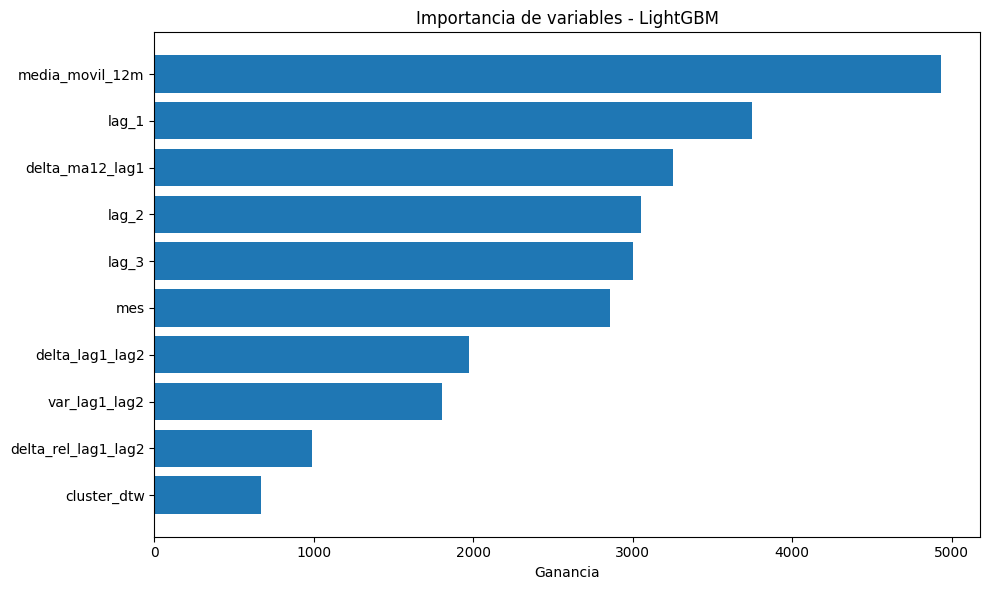

In [ ]:
# Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\nImportancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [ ]:
# Comparación por producto
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada', 'media_movil_12m']].copy()

# Totales agregados
total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()
total_febrero_hist = comparacion['media_movil_12m'].sum()

print("Comparación de totales:")
print(f"Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"Predicción ajustada (65/35)......: {total_ajustada:,.2f} tn")
print(f"Promedio histórico 12m.......: {total_febrero_hist:,.2f} tn")



🔎 Comparación de totales:
📉 Predicción solo modelo...........: 28,798.77 tn
⚖️  Predicción ajustada (65/35)......: 29,180.10 tn
📜 Promedio histórico 12m.......: 29,888.29 tn
